In [35]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

In [36]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [37]:
train_data = datasets.load_dataset("XiangPan/waimai_10k", split="train")
train_data=train_data.shuffle(42)
train_data, test_data = train_data.train_test_split(test_size=0.2).values()
train_data, test_data

Using the latest cached version of the dataset since XiangPan/waimai_10k couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\洋\.cache\huggingface\datasets\XiangPan___waimai_10k\default\0.0.0\dbb125403842b8924d864f09f1c0eb357bd57435 (last modified on Mon Mar 24 15:30:14 2025).


(Dataset({
     features: ['label', 'text'],
     num_rows: 9589
 }),
 Dataset({
     features: ['label', 'text'],
     num_rows: 2398
 }))

In [38]:
transformer_name = "bert-base-chinese"

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

In [39]:
tokenizer.tokenize("我的梦想！")

['我', '的', '梦', '想', '！']

In [40]:
tokenizer.encode("我的梦想！")

[101, 2769, 4638, 3457, 2682, 8013, 102]

In [41]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("我的梦想!"))

['[CLS]', '我', '的', '梦', '想', '!', '[SEP]']

In [42]:
tokenizer("我的梦想！")

{'input_ids': [101, 2769, 4638, 3457, 2682, 8013, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [43]:
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["text"], truncation=True)["input_ids"]
    return {"ids": ids}

In [44]:
train_data = train_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

Map: 100%|██████████| 2398/2398 [00:00<00:00, 9272.64 examples/s]


In [45]:
train_data

Dataset({
    features: ['label', 'text', 'ids'],
    num_rows: 9589
})

In [46]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [47]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [48]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [49]:
pad_index = tokenizer.pad_token_id
batch_size = 8

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [50]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [51]:
transformer = transformers.AutoModel.from_pretrained("bert-base-chinese")

In [52]:
transformer.config.hidden_size

768

In [53]:
output_dim = len(train_data["label"].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [54]:
def count_parameters(model):
    """
    计算模型中可训练参数的数量。

    参数:
    model (nn.Module): 要计算参数数量的 PyTorch 模型。

    返回:
    int: 模型中可训练参数的数量。
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 打印模型可训练参数的数量
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 102,269,186 trainable parameters


In [55]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [56]:
model = model.to(device)
criterion = criterion.to(device)

In [57]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [58]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [59]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [60]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(test_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 300/300 [00:07<00:00, 39.61it/s]


epoch: 0
train_loss: 0.283, train_acc: 0.889
valid_loss: 0.218, valid_acc: 0.917


evaluating...: 100%|██████████| 300/300 [00:07<00:00, 37.83it/s]


epoch: 1
train_loss: 0.207, train_acc: 0.925
valid_loss: 0.215, valid_acc: 0.922


evaluating...: 100%|██████████| 300/300 [00:09<00:00, 31.16it/s]


epoch: 2
train_loss: 0.150, train_acc: 0.945
valid_loss: 0.237, valid_acc: 0.912


evaluating...: 100%|██████████| 300/300 [00:09<00:00, 33.18it/s]


epoch: 3
train_loss: 0.103, train_acc: 0.964
valid_loss: 0.264, valid_acc: 0.917


evaluating...: 100%|██████████| 300/300 [00:08<00:00, 33.51it/s]


epoch: 4
train_loss: 0.073, train_acc: 0.973
valid_loss: 0.327, valid_acc: 0.914


evaluating...: 100%|██████████| 300/300 [00:09<00:00, 32.98it/s]


epoch: 5
train_loss: 0.051, train_acc: 0.981
valid_loss: 0.329, valid_acc: 0.910


evaluating...: 100%|██████████| 300/300 [00:08<00:00, 36.08it/s]


epoch: 6
train_loss: 0.040, train_acc: 0.986
valid_loss: 0.407, valid_acc: 0.909


evaluating...: 100%|██████████| 300/300 [00:08<00:00, 36.55it/s]


epoch: 7
train_loss: 0.033, train_acc: 0.989
valid_loss: 0.400, valid_acc: 0.903


evaluating...: 100%|██████████| 300/300 [00:08<00:00, 33.96it/s]


epoch: 8
train_loss: 0.028, train_acc: 0.990
valid_loss: 0.467, valid_acc: 0.908


evaluating...: 100%|██████████| 300/300 [00:11<00:00, 26.56it/s]

epoch: 9
train_loss: 0.032, train_acc: 0.989
valid_loss: 0.494, valid_acc: 0.894


valid_loss: 0.494, valid_acc: 0.894


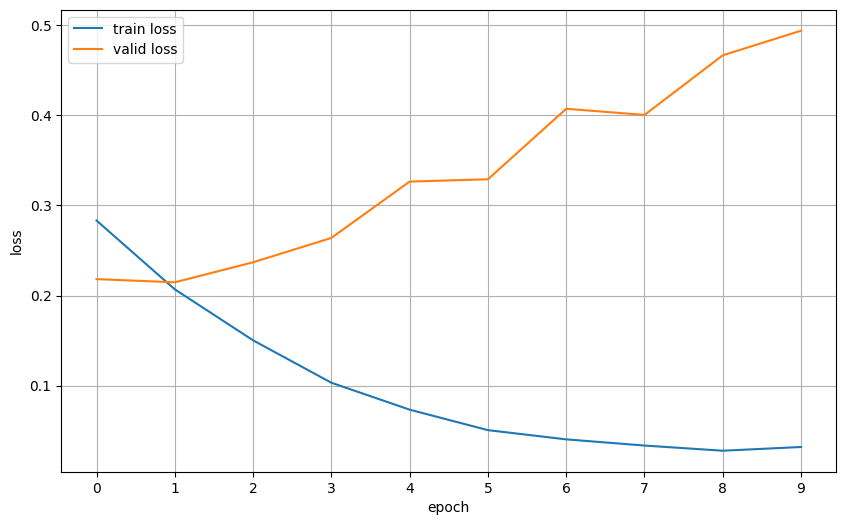

In [61]:
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

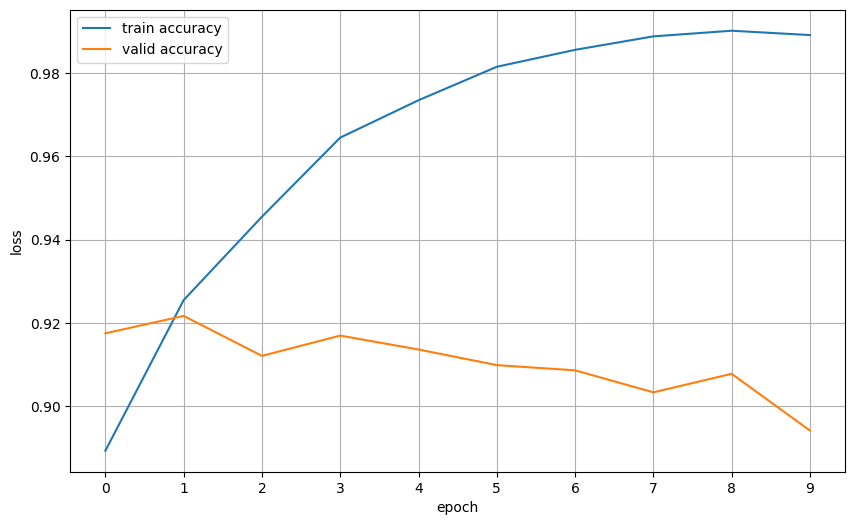

In [62]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [63]:
model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

evaluating...: 100%|██████████| 300/300 [00:13<00:00, 22.21it/s]

test_loss: 0.215, test_acc: 0.922


In [74]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [75]:
text = "这个外卖好好吃！"

predict_sentiment(text, model, tokenizer, device)

(1, 0.9786320924758911)

In [77]:
text = "这个外卖做的不够权威！"

predict_sentiment(text, model, tokenizer, device)

(0, 0.9478872418403625)